## Baseline Filter and Experiment Merge

- Filtering based on "normal" initial timepoint behavior and final merging of multi-experiment dataframes

In [2]:
import trenchripper as tr

import warnings
import random
import scipy.stats

import numpy as np
import scipy as sp
import pandas as pd
import dask.dataframe as dd

from dask.distributed import wait

from matplotlib import pyplot as plt

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"

warnings.filterwarnings(action='once',category=UserWarning)

### Initial Data Processing

#### Start Dask

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=40,
    n_workers_min=40,
    memory="16GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

#small testing deployment

# dask_controller = tr.trcluster.dask_controller(
#     walltime="02:00:00",
#     local=False,
#     n_workers=40,
#     n_workers_min=40,
#     memory="16GB",
#     working_directory=dask_wd,
# )
# dask_controller.startdask()

110m
02:00:00


Task exception was never retrieved
future: <Task finished name='Task-4179' coro=<Client._gather.<locals>.wait() done, defined at /home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


In [4]:
dask_controller.displaydashboard()

#### Merge Dataframes

In [4]:
basepath = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1"
# basepath = "/home/de64/scratch/de64/sync_folder/2023-01-18_lDE20_Merged_Analysis/"
# n_runs = 4
n_partitions = 500

cell_cycle_df_paths = ["/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Lineage_Cell_Cycle_At_Segregation_Time"]
timepoints_df_paths = ["/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Lineage_Observations"]
growth_df_paths = ["/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Lineage_Growth_Observations"]
barcode_df_paths = ["/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Final_Barcodes_df"]

cell_cycle_df_list = [dd.read_parquet(cell_cycle_df_path,engine="pyarrow",calculate_divisions=True) for cell_cycle_df_path in cell_cycle_df_paths]
cell_cycle_df = dd.concat(cell_cycle_df_list).repartition(npartitions=n_partitions)
cell_cycle_df = cell_cycle_df.dropna(subset=['Growth Rate: Volume','Delta time (s)','Division: Volume'])
cell_cycle_df = cell_cycle_df.reset_index()
cell_cycle_df['Multi-Experiment Phenotype Trenchid'] = cell_cycle_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["phenotype trenchid"]):08n}'), axis=1, meta=("Multi-Experiment Phenotype Trenchid",int))
cell_cycle_df['Multi-Experiment Global CellID'] = cell_cycle_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["Global CellID"]):013n}'), axis=1, meta=("Multi-Experiment Global CellID",int))
cell_cycle_df['Multi-Experiment FOV'] = cell_cycle_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["fov"]):05n}'), axis=1, meta=("Multi-Experiment FOV",int))
cell_cycle_df = cell_cycle_df.set_index('Multi-Experiment Phenotype Trenchid',sorted=True).persist()

timepoints_df_list = [dd.read_parquet(timepoints_df_path,engine="pyarrow",calculate_divisions=True) for timepoints_df_path in timepoints_df_paths]
for i in range(len(timepoints_df_list)):
    timepoints_df_list[i]["Experiment #"] = i
timepoints_df = dd.concat(timepoints_df_list).repartition(npartitions=n_partitions)
timepoints_df = timepoints_df.dropna(subset=['Length','Width','YFP mean_intensity'])
timepoints_df = timepoints_df.reset_index()
timepoints_df['Multi-Experiment Phenotype Trenchid'] = timepoints_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["phenotype trenchid"]):08n}'), axis=1, meta=("Multi-Experiment Phenotype Trenchid",int))
timepoints_df['Multi-Experiment Global CellID'] = timepoints_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["Global CellID"]):013n}'), axis=1, meta=("Multi-Experiment Global CellID",int))
timepoints_df = timepoints_df.set_index('Multi-Experiment Phenotype Trenchid',sorted=True).persist()

growth_df_list = [dd.read_parquet(growth_df_path,engine="pyarrow",calculate_divisions=True) for growth_df_path in growth_df_paths]
for i in range(len(growth_df_list)):
    growth_df_list[i]["Experiment #"] = i
growth_df = dd.concat(growth_df_list).repartition(npartitions=n_partitions)
growth_df = growth_df.dropna(subset=['Instantaneous Growth Rate: Volume'])
growth_df = growth_df.reset_index()
growth_df['Multi-Experiment Phenotype Trenchid'] = growth_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["phenotype trenchid"]):08n}'), axis=1, meta=("Multi-Experiment Phenotype Trenchid",int))
growth_df['Multi-Experiment Global CellID'] = growth_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["Global CellID"]):013n}'), axis=1, meta=("Multi-Experiment Global CellID",int))
growth_df = growth_df.set_index('Multi-Experiment Phenotype Trenchid',sorted=True).persist()


#### Filter for "Normal" Sizes at Start

1) Fit a gaussian model to each of the specified feature params during the first t timepoints of the experiment (using a subsample for speed) 
2) Compute a normalized probability trenchwise for these features under the gaussian model, during the first t timepoints of the experiment
3) Eliminate trenches that are under some p percentile value of this probability for each feature
4) Display histograms for each property as well as the resulting theshold

Note that these features should be the only features examined in the resulting analysis. For the notebook, I am looking at:
- Birth length (Lb)
- Division length (Ld)
- Mean Area Increment
- Mean Length Increment
- Mean Width
- Cell cycle duration (Delta t)
- Mean mCherry Intensity

In [13]:
def remove_early_outliers(final_output_df_lineage,final_output_df_lineage_timepoints,final_output_df_lineage_growth,\
                          early_time_cutoff=14400,gaussian_subsample_rates = [0.2,0.1,0.1],percentile_threshold = 10,
                          cell_cycle_params=['Division: Length'],timepoint_params=['Length','Width','YFP mean_intensity', 'Total Nucleoid Area'],\
                          growth_params=["Instantaneous Growth Rate: Volume"],
                         plot_values_names = ['Division Length','Length','Width','YFP Intensity','Growth Rate', 'Total Nucleoid Area'],trench_lookup_column='Multi-Experiment Phenotype Trenchid'):
    
    final_output_df_trench_groupby = final_output_df_lineage.groupby(trench_lookup_column,sort=False)
    final_output_df_lineage_timepoints_groupby = final_output_df_lineage_timepoints.groupby(trench_lookup_column,sort=False)
    final_output_df_lineage_growth_groupby = final_output_df_lineage_growth.groupby(trench_lookup_column,sort=False)
    
    early_tpt_df = final_output_df_trench_groupby.apply(lambda x: x[x['Final time (s)']<early_time_cutoff].reset_index(drop=True)).persist()
    early_tpt_df_timepoints = final_output_df_lineage_timepoints_groupby.apply(lambda x: x[x['Observation time (s)']<early_time_cutoff].reset_index(drop=True)).persist()
    early_tpt_df_growth = final_output_df_lineage_growth_groupby.apply(lambda x: x[x['Measurement time (s)']<early_time_cutoff].reset_index(drop=True)).persist()
    
    for filter_param in cell_cycle_params:
        early_param_series = early_tpt_df[filter_param]
        all_param_values = early_param_series.sample(frac=gaussian_subsample_rates[0]).compute().tolist()
        gaussian_fit = sp.stats.norm.fit(all_param_values)
        gaussian_fit = sp.stats.norm(loc=gaussian_fit[0], scale=gaussian_fit[1])
                
        early_param_series = dd.from_pandas(early_param_series.compute().droplevel(1),npartitions=50)
        trench_probability = early_param_series.groupby(trench_lookup_column).apply(lambda x: np.exp(np.sum(gaussian_fit.logpdf(x))/len(x)), meta=float)

        final_output_df_lineage[filter_param + ": Probability"] = trench_probability.persist()
        
    for filter_param in timepoint_params:
        early_param_series = early_tpt_df_timepoints[filter_param]
        all_param_values = early_param_series.sample(frac=gaussian_subsample_rates[1]).compute().tolist()
        gaussian_fit = sp.stats.norm.fit(all_param_values)
        gaussian_fit = sp.stats.norm(loc=gaussian_fit[0], scale=gaussian_fit[1])

        early_param_series = dd.from_pandas(early_param_series.compute().droplevel(1),npartitions=50)
        trench_probability = early_param_series.groupby(trench_lookup_column).apply(lambda x: np.exp(np.sum(gaussian_fit.logpdf(x))/len(x)), meta=float)

        final_output_df_lineage_timepoints[filter_param + ": Probability"] = trench_probability.persist()
        
    for filter_param in growth_params:
        early_param_series = early_tpt_df_growth[filter_param]
        all_param_values = early_param_series.sample(frac=gaussian_subsample_rates[2]).compute().tolist()
        gaussian_fit = sp.stats.norm.fit(all_param_values)
        gaussian_fit = sp.stats.norm(loc=gaussian_fit[0], scale=gaussian_fit[1])

        early_param_series = dd.from_pandas(early_param_series.compute().droplevel(1),npartitions=50)
        trench_probability = early_param_series.groupby(trench_lookup_column).apply(lambda x: np.exp(np.sum(gaussian_fit.logpdf(x))/len(x)), meta=float)

        final_output_df_lineage_growth[filter_param + ": Probability"] = trench_probability.persist()
            
    final_output_df_onetrench = final_output_df_lineage.groupby(trench_lookup_column).first().compute()
    final_output_df_timepoints_onetrench = final_output_df_lineage_timepoints.groupby(trench_lookup_column).first().compute()
    final_output_df_growth_onetrench = final_output_df_lineage_growth.groupby(trench_lookup_column).first().compute()

    plt.figure(figsize=(22,16))

    lineage_query_list = []
    plot_idx = 0
    for i,filter_param in enumerate(cell_cycle_params):
        prob_threshold = np.nanpercentile(final_output_df_onetrench[filter_param + ": Probability"].tolist(),percentile_threshold)
        query = "`"+filter_param+": Probability` > " + str(prob_threshold)
        lineage_query_list.append(query)

        min_v,max_v = np.nanpercentile(final_output_df_onetrench[filter_param+": Probability"],percentile_threshold/2),np.max(final_output_df_onetrench[filter_param+": Probability"])

        plt.subplot(2,3,plot_idx+1)
        plt.title(plot_values_names[plot_idx],fontsize=22)
        plt.xlabel("Unnormalized Likelihood", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.hist(final_output_df_onetrench[final_output_df_onetrench[filter_param+": Probability"]<prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plt.hist(final_output_df_onetrench[final_output_df_onetrench[filter_param+": Probability"]>=prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plot_idx += 1
        
    lineage_timepoint_query_list = []
    for i,filter_param in enumerate(timepoint_params):
        prob_threshold = np.nanpercentile(final_output_df_timepoints_onetrench[filter_param + ": Probability"].tolist(),percentile_threshold)
        query = "`"+filter_param+": Probability` > " + str(prob_threshold)
        lineage_timepoint_query_list.append(query)

        min_v,max_v = np.nanpercentile(final_output_df_timepoints_onetrench[filter_param+": Probability"],percentile_threshold/2),np.max(final_output_df_timepoints_onetrench[filter_param+": Probability"])

        plt.subplot(2,3,plot_idx+1)
        plt.title(plot_values_names[plot_idx],fontsize=22)
        plt.xlabel("Unnormalized Likelihood", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.hist(final_output_df_timepoints_onetrench[final_output_df_timepoints_onetrench[filter_param+": Probability"]<prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plt.hist(final_output_df_timepoints_onetrench[final_output_df_timepoints_onetrench[filter_param+": Probability"]>=prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plot_idx += 1
        
    lineage_growth_query_list = []
    for i,filter_param in enumerate(growth_params):
        prob_threshold = np.nanpercentile(final_output_df_growth_onetrench[filter_param + ": Probability"].tolist(),percentile_threshold)
        query = "`"+filter_param+": Probability` > " + str(prob_threshold)
        lineage_growth_query_list.append(query)

        min_v,max_v = np.nanpercentile(final_output_df_growth_onetrench[filter_param+": Probability"],percentile_threshold/2),np.max(final_output_df_growth_onetrench[filter_param+": Probability"])

        plt.subplot(2,3,plot_idx+1)
        plt.title(plot_values_names[plot_idx],fontsize=22)
        plt.xlabel("Unnormalized Likelihood", fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.hist(final_output_df_growth_onetrench[final_output_df_growth_onetrench[filter_param+": Probability"]\
                                                            <prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plt.hist(final_output_df_growth_onetrench[final_output_df_growth_onetrench[filter_param+": Probability"]\
                                                            >=prob_threshold][filter_param+": Probability"].tolist(),bins=50,range=(min_v,max_v))
        plot_idx += 1

    compiled_lineage_query = ' and '.join(lineage_query_list)
    compiled_lineage_timepoint_query = ' and '.join(lineage_timepoint_query_list)
    compiled_lineage_growth_query = ' and '.join(lineage_growth_query_list)
    
    final_output_df_onetrench_filtered = final_output_df_onetrench.query(compiled_lineage_query)
    final_output_df_timepoints_onetrench_filtered = final_output_df_timepoints_onetrench.query(compiled_lineage_timepoint_query)
    final_output_df_growth_onetrench_filtered = final_output_df_growth_onetrench.query(compiled_lineage_growth_query)
    
    all_idx_list = sorted((set(final_output_df_onetrench_filtered.index.tolist())&set(final_output_df_timepoints_onetrench_filtered.index.tolist()))
                    &set(final_output_df_growth_onetrench_filtered.index.tolist()))

    final_output_df_filtered = final_output_df_lineage.loc[all_idx_list].persist()
    final_output_df_timepoints_filtered = final_output_df_lineage_timepoints.loc[all_idx_list].persist()
    final_output_df_growth_filtered = final_output_df_lineage_growth.loc[all_idx_list].persist()
    
    return final_output_df_filtered,final_output_df_timepoints_filtered,final_output_df_growth_filtered

/tmp/ipykernel_12643/1765875646.py:11: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  early_tpt_df = final_output_df_trench_groupby.apply(lambda x: x[x['Final time (s)']<early_time_cutoff].reset_index(drop=True)).persist()
/tmp/ipykernel_12643/1765875646.py:12: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  early_tpt_df_timepoints = final_output_df_lineage_timepoints_groupby.apply(lambda x: x[x['Observation time (s)']<early_time_cutoff].reset_index(drop=True)).persist()
/tmp/ipykernel_12643/1765875646.py:13: UserWarnin

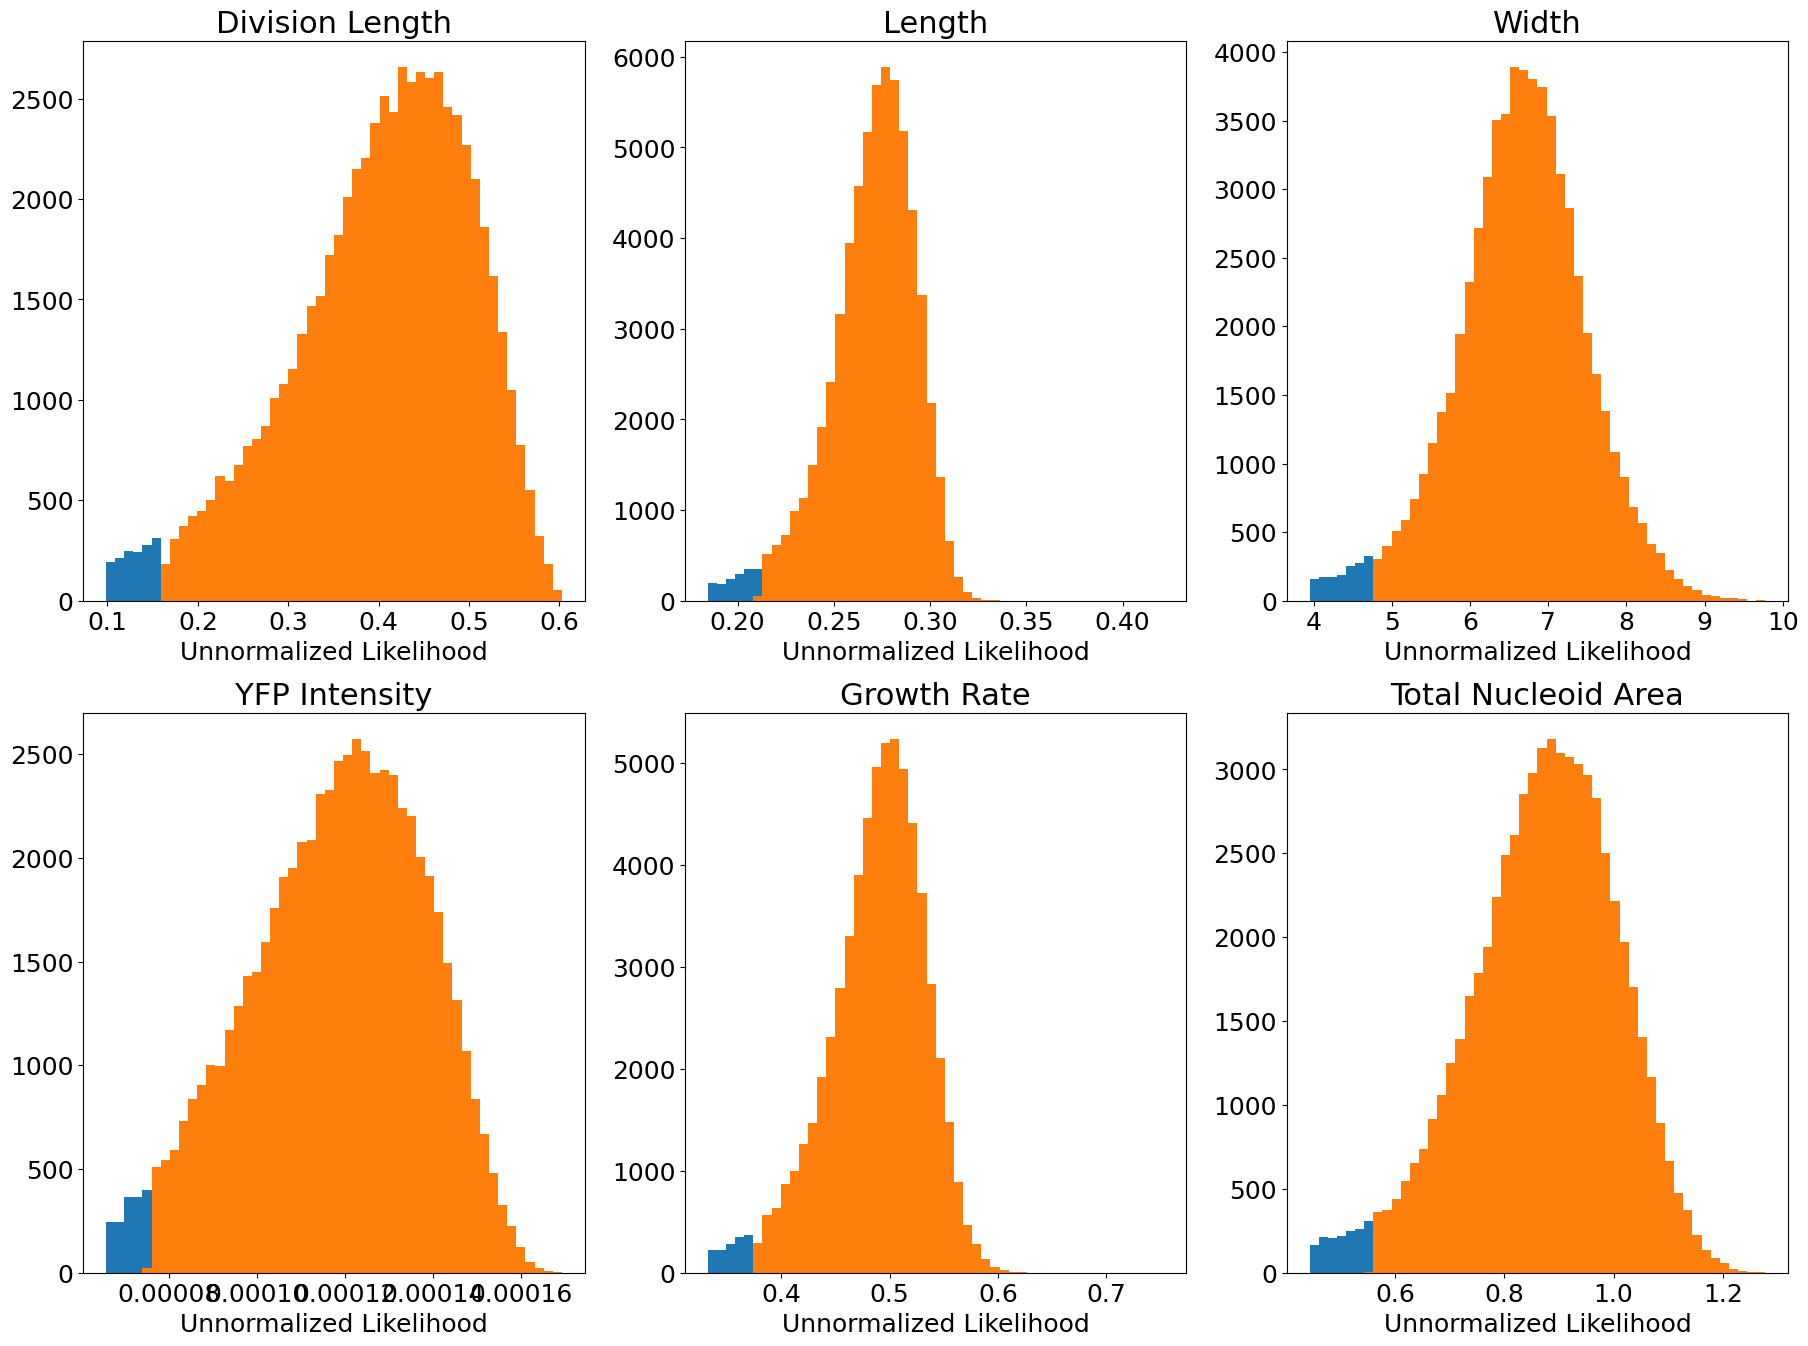

In [14]:
cell_cycle_df_filtered,timepoints_df_filtered,growth_df_filtered = \
    remove_early_outliers(cell_cycle_df,timepoints_df,growth_df,\
    early_time_cutoff=7200,gaussian_subsample_rates =  [0.2,0.1,0.1],percentile_threshold = 5)

plt.savefig("Prob_threshold_Replicate_1.png",dpi=500)

In [15]:
print(len(cell_cycle_df_filtered)/len(cell_cycle_df))
print(len(timepoints_df_filtered)/len(timepoints_df))
print(len(growth_df_filtered)/len(growth_df))

0.8158905458880604
0.8139938050680445
0.8166351212793879


In [16]:
cell_cycle_df_filtered.to_parquet(basepath + "_Lineage_Cell_Cycle_Merged", engine="pyarrow", overwrite=True)
dask_controller.daskclient.cancel(cell_cycle_df)
dask_controller.daskclient.cancel(cell_cycle_df_filtered)
timepoints_df_filtered.to_parquet(basepath + "_Lineage_Observations_Merged", engine="pyarrow", overwrite=True)
dask_controller.daskclient.cancel(timepoints_df)
dask_controller.daskclient.cancel(timepoints_df_filtered)
growth_df_filtered.to_parquet(basepath + "_Lineage_Growth_Observations_Merged", engine="pyarrow", overwrite=True)
dask_controller.daskclient.cancel(growth_df)
dask_controller.daskclient.cancel(growth_df_filtered)

In [17]:
barcode_df_list = [dd.read_parquet(barcode_df_path,engine="pyarrow",calculate_divisions=True) for barcode_df_path in barcode_df_paths]
for i in range(len(barcode_df_list)):
    barcode_df_list[i]["Experiment #"] = i
barcode_df = dd.concat(barcode_df_list)
barcode_df = barcode_df.reset_index()
barcode_df['Multi-Experiment Phenotype Trenchid'] = barcode_df.apply(lambda x: int(f'{int(x["Experiment #"]):02n}{int(x["phenotype trenchid"]):08n}'), axis=1, meta=("Multi-Experiment Phenotype Trenchid",int))
barcode_df = barcode_df.set_index('Multi-Experiment Phenotype Trenchid',sorted=True).repartition(partition_size="2GB").persist()

barcode_df.to_parquet(basepath + "_lDE26_Final_Barcodes_df_Merged", engine="pyarrow", overwrite=True)
dask_controller.daskclient.cancel(barcode_df)

### Special Export for Width Analysis (Figure S12)

In [7]:
lDE26_cell_cycle = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_Lineage_Cell_Cycle_Merged",calculate_divisions=True)
lDE26_barcodes = dd.read_parquet("/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/2023-04-21_lDE26_Run_1_lDE26_Final_Barcodes_df_Merged",calculate_divisions=True)

In [8]:
rod_complex = ['mrdA','mrdB','mreB','mreC','mreD','rodZ']
UDP_NAG_Synthesis = ['glmS','glmM','glmU']

lDE26_barcodes_cell_wall = lDE26_barcodes[lDE26_barcodes["Gene"].isin(rod_complex + UDP_NAG_Synthesis)].compute()
cell_wall_trenchids = lDE26_barcodes_cell_wall.index.unique().tolist()
cell_cycle_idx = lDE26_cell_cycle.index.unique().compute()
cell_wall_trenchids = list(set(cell_wall_trenchids)&set(cell_cycle_idx))
lDE26_cell_cycle_cell_wall = lDE26_cell_cycle.loc[cell_wall_trenchids].compute()

lDE26_cell_cycle_cell_wall.to_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/Raw_Cell_Width_Data.csv")
lDE26_cell_cycle_cell_wall.to_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/Raw_Cell_Width_Data.pkl")

In [11]:
dask_controller.shutdown()

Done.


2025-06-07 16:02:04,601 - distributed.deploy.adaptive_core - INFO - Adaptive stop
